##### Author: Vamsi Tallam 


This notebook is organised as the following:


1.   Install and load all the necessary packages
2.   Data loading and pre-processing 
3.   Model Architecture followed by Model Training and Testing
4.   Results and Conclusion
5.   Experimentation


##  Step - 1: Install and load all the necessary Packages 

In [ ]:
# Install packages
!pip install keras-tqdm
!pip install scikit-plot

TQDM is a progress bar library with good support for nested loops and Jupyter/IPython notebooks


In [ ]:
# Import necessary Libraries to run the code

import os
import time
import keras
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import LSTM,Dense, Dropout, BatchNormalization
from keras.callbacks import TensorBoard
from keras_tqdm import TQDMNotebookCallback
# from keras_tqdm import TQDMCallback

import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score
from imblearn.pipeline import make_pipeline
from imblearn.base import BaseSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import (SMOTE, RandomOverSampler)
from imblearn.combine import SMOTEENN, SMOTETomek

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### End of Step - 1

## Step - 2: Data Loading and pre-processing

Dataset used for training and testing - Yahoo webscope dataset. We used A1 Benchmark dataset and A2 Benchmark dataset.
1.   A1Benchmark dataset consists of real user yahoo login data. We use A1Benchmark to draw inferences and model performance.
2.   A2Benchmark is a synthetic dataset, we test on A2 for completeness and to assess our model performance on synthetic dataset.



In [ ]:
# Takes the path of files to load and returns transformed data and their lables
def files_data_loading(repo_files):
	repo_data = []
	repo_target_data = []
	for file_name in repo_files:
		df = pd.read_csv(file_name, usecols=[1, 2], header=0, names=['value', 'anomaly'])
		
		# Convert the values to float
		values = df[['value']].values.astype(np.float32)
		targets = df[['anomaly']].values.astype(np.float32)
		
		# Transforms data and converts them to between 0 and 1 using
		# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))		# X_scaled = X_std * (max - min) + min
		scaler = MinMaxScaler()
		scaled_values = scaler.fit_transform(values)
		scaled_targets = scaler.fit_transform(targets)
		
		repo_data.append(scaled_values)
		repo_target_data.append(targets)

	return repo_data, repo_target_data

In [ ]:
# Assign path and Initialize variables
DATASET = 'A1Benchmark' 		# To load time series data from A1 Benchmark
# DATASET = 'A2Benchmark' 	# To load time series data from A2 Benchmark
EPOCHS = 10 								# Number of Epocjs
TRAIN_SPLIT = 0.7						# we have 70-30 split. 
# MODEL_NAME = DATASET+'_context_withoutPER_'+str(EPOCHS)+'_split='+str(TRAIN_SPLIT) # When we have several models, to save names of each model
MODEL_NAME = 'Final'
REPO_DIR = 'drive/MyDrive/dataset/ydata-labeled-time-series-anomalies-v1_0/'+DATASET # path to the directory

# To provide the context we have a sliding window of size 10, this factor can be tweaked based on how much context is relevant
LOOK_BACK = 10
FEATURES = 2
SHAPE = (LOOK_BACK, FEATURES)

# Initialize the following variables with empty list
repo_files = []
x_train = []
y_train = []
x_test = []
y_test = []
total_x = []
total_y = []

In [ ]:
# Fetch the paths of all files to be used for training and testing
for subdir, dirs, files in os.walk(REPO_DIR):
	for file in files:
		if file.find('.csv') != -1:
			repo_files.append(os.path.join(subdir, file))
   
# Load the data from all the paths 
repo_data, repo_target_data = files_data_loading(repo_files)
total_files = len(repo_data)

In [ ]:
# Generate training samples and testing samples from each files in the 70-30 split
# We introduced feedback in this block. 
# Data sample is obtained by appending true feedback with lag-1 to the sequence of data extracted using the sliding window
# Convert the training and testing data to np array to make it compatiable for training and testing.
for file in np.random.permutation(len(repo_target_data)):
	data_x = repo_data[file]
	data_y = repo_target_data[file]
	len_data = len(data_x)
	for index in range(0, len_data-LOOK_BACK):
		a = data_x[index: index+LOOK_BACK]
		if index == 0:
			b = np.zeros((LOOK_BACK, 1))
		else:
			b = data_y[index-1:index+LOOK_BACK-1]
		state = np.append(a, b, axis=1)
		total_x.append(state)
		total_y.append(data_y[index+LOOK_BACK-1])
		if index >= len_data*TRAIN_SPLIT:
			x_test.append(state)
			y_test.append(data_y[index+LOOK_BACK-1])
			
		else:
			x_train.append(state)
			y_train.append(data_y[index+LOOK_BACK-1])

# make the data compatiable for training
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = np.array(x_train)
y_train = np.array(y_train)


### End of Step - 2

## Step - 3: Model Architecture, Model Training and Testing

In [ ]:
# We have experimented several Architectures 
# We tried multiple layers, varing LSTM units, various optimizers, various loss functions, dropouts, and activation function
# The following configuration is best we have seen.

model = Sequential()
model.add(LSTM(128, input_shape=SHAPE))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Model training and testing
# we reduced number of epochs to avoid overfitting
# Tried several Batch sizes and we got better results with 128 
model.fit(x_train, y_train, epochs = 10, batch_size = 128)
y_pred = model.predict(x_test, batch_size=128)


Epoch 1/10
519/519 [==============================] - 19s 32ms/step - loss: 0.0393 - accuracy: 0.9947
Epoch 2/10
519/519 [==============================] - 17s 33ms/step - loss: 0.0181 - accuracy: 0.9967
Epoch 3/10
519/519 [==============================] - 16s 30ms/step - loss: 0.0152 - accuracy: 0.9972
Epoch 4/10
519/519 [==============================] - 16s 30ms/step - loss: 0.0134 - accuracy: 0.9974
Epoch 5/10
519/519 [==============================] - 16s 30ms/step - loss: 0.0124 - accuracy: 0.9974
Epoch 6/10
519/519 [==============================] - 16s 30ms/step - loss: 0.0117 - accuracy: 0.9976
Epoch 7/10
519/519 [==============================] - 16s 31ms/step - loss: 0.0114 - accuracy: 0.9978
Epoch 8/10
519/519 [==============================] - 16s 31ms/step - loss: 0.0112 - accuracy: 0.9976
Epoch 9/10
519/519 [==============================] - 16s 32ms/step - loss: 0.0110 - accuracy: 0.9978
Epoch 10/10
519/519 [==============================] - 16s 31ms/step - loss: 0.011

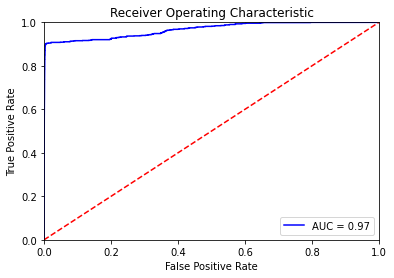

In [ ]:
# To best summarize our model performance we use RoC curve, confusion matrix and the classification report
# tpr - True Positive Rate
# fpr - False Positive Rate  
# thr - Threshold at which we get optimal performance
fpr, tpr, thr = roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix for A1 Benchmark


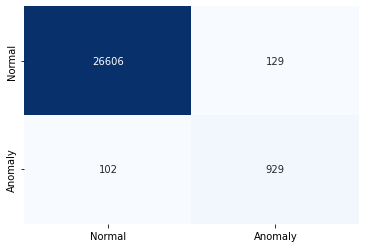

In [ ]:
# To generate confusion matrix
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thr[optimal_idx]
# print("Threshold value is:", optimal_threshold)
y_pred_bool = (y_pred>optimal_threshold)
cf_matrix  = confusion_matrix(y_test, y_pred_bool)
axis_labels = ['Normal', 'Anomaly']
sns.heatmap(cf_matrix, cmap = 'Blues', annot=True, cbar= False, fmt='g',  xticklabels = axis_labels, yticklabels = axis_labels)
print("Confusion Matrix for A1 Benchmark")

In [ ]:
# To generate results
print('Classification report for A1Benchmark')
print(classification_report(y_test, y_pred_bool,target_names=['Normal','Anomaly']))

Classification report for A1Benchmark
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     26735
     Anomaly       0.88      0.90      0.89      1031

    accuracy                           0.99     27766
   macro avg       0.94      0.95      0.94     27766
weighted avg       0.99      0.99      0.99     27766



### End of step - 3

## Step - 4: Results and Conclusion

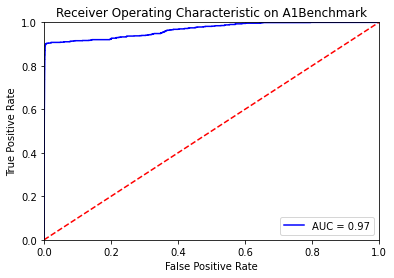

In [ ]:
# To best summarize our model performance we use RoC curve, confusion matrix and the classification report
# tpr - True Positive Rate
# fpr - False Positive Rate  
# thr - Threshold at which we get optimal performance
fpr, tpr, thr = roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic on A1Benchmark')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix for A1Benchmark


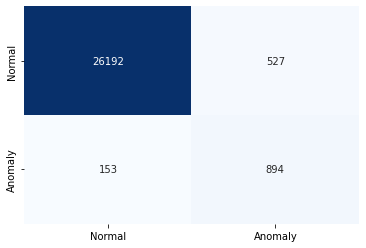

In [ ]:
# To generate confusion matrix
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thr[optimal_idx]
# print("Threshold value is:", optimal_threshold)
y_pred_bool = (y_pred>optimal_threshold)
cf_matrix  = confusion_matrix(y_test, y_pred_bool)
axis_labels = ['Normal', 'Anomaly']
sns.heatmap(cf_matrix, cmap = 'Blues', annot=True, cbar= False, fmt='g',  xticklabels = axis_labels, yticklabels = axis_labels)
print("Confusion Matrix for A1Benchmark")

In [ ]:
# To generate results
print('Classification report for A1Benchmark')
print(classification_report(y_test, y_pred_bool,target_names=['Normal','Anomaly']))

Classification report for A1Benchmark
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99     26719
     Anomaly       0.63      0.85      0.72      1047

    accuracy                           0.98     27766
   macro avg       0.81      0.92      0.86     27766
weighted avg       0.98      0.98      0.98     27766



We tested the perfomance of our model on a random file and compare the predicted against the actual labels. We have the following steps:
1.   Generate a random random to select a file
2.   Data processing for the file, extract the data, append true feedback and perform operations.
3. Use the final model we just trained to predict lables
4. plot the results to compare true vs predicted


Confusion Matrix for Random Sample in A1Benchmark
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1349
     Anomaly       0.95      0.94      0.94        82

    accuracy                           0.99      1431
   macro avg       0.97      0.97      0.97      1431
weighted avg       0.99      0.99      0.99      1431

Heatmap for a Random Sample in A1Benchmark


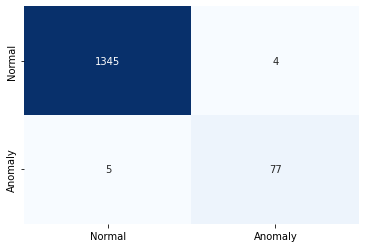

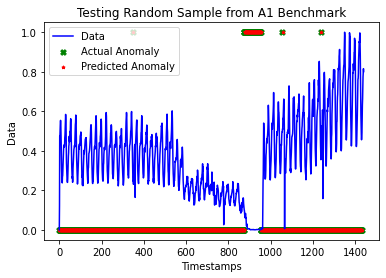

In [ ]:
# Random number is 35.
ind = 35
file = ind
x_test_ind = []
y_test_ind = []
total_x_ind = []
total_y_ind = []

# Extract the data from the file and generate sample for testing
if(file == ind):
	data_x = repo_data[file]
	data_y = repo_target_data[file]
	len_data = len(data_x)
	for index in range(0, len_data-LOOK_BACK):
		a = data_x[index: index+LOOK_BACK]
		if index == 0:
			b = np.zeros((LOOK_BACK, 1))
		else:
			b = data_y[index-1:index+LOOK_BACK-1]
		state = np.append(a, b, axis=1)
		total_x_ind.append(state)
		total_y_ind.append(data_y[index+LOOK_BACK-1])
		x_test_ind.append(state)
		y_test_ind.append(data_y[index+LOOK_BACK-1])

x_test_ind = np.array(x_test_ind)
y_test_ind = np.array(y_test_ind)
y_pred_ind = model.predict(x_test_ind, batch_size=128)

fpr_ind, tpr_ind, thr_ind = roc_curve(y_test_ind, y_pred_ind)
roc_auc_ind = metrics.auc(fpr_ind, tpr_ind)

optimal_idx_ind = np.argmax(tpr_ind - fpr_ind)
optimal_threshold_ind= thr_ind[optimal_idx_ind]
#print("Threshold value is:", optimal_threshold_ind)

y_pred_bool_ind = (y_pred_ind>optimal_threshold_ind)
cf_matrix  = confusion_matrix(y_test_ind, y_pred_bool_ind)
axis_labels = ['Normal', 'Anomaly']

print("Confusion Matrix for Random Sample in A1Benchmark")
print(classification_report(y_test_ind, y_pred_bool_ind,target_names=['Normal','Anomaly']))

print("Heatmap for a Random Sample in A1Benchmark")
sns.heatmap(cf_matrix, cmap = 'Blues', annot=True, cbar= False, fmt='g',  xticklabels = axis_labels, yticklabels = axis_labels)


plt.figure()
plt.plot(repo_data[ind], color = 'blue')
plt.scatter(range(len(y_pred_bool_ind)), repo_target_data[ind][10:len(repo_target_data[ind])], marker='X', c= 'G', s=30)
plt.scatter(range(len(y_pred_bool_ind)), y_pred_bool_ind, marker='*', c= 'R', s=10)
plt.xlabel('Timestamps')
plt.ylabel('Data')
plt.legend(['Data','Actual Anomaly', 'Predicted Anomaly'])
plt.title("Testing Random Sample from A1 Benchmark")
plt.show()


#### Conclusion: Our model performs well with a high accuracy. 
#### Inference: Using true feedback and careful model selection are the key 

### End of Step - 4

## Step - 5: Experimentation

#### We have tried several architectures, various sliding window, true feedback vs estimated feedback. 
#### We have also tried data imbalance problem
#### To give the reader a flavour of our experiements we picked the following: 

1.   Model performance on Synthetic data (A2Benchmark)
2.   True feedback vs Estimated feedback
3.   Imbalaned Data Problem



#### Model performance on A2Benchmark

Epoch 1/10
694/694 [==============================] - 24s 32ms/step - loss: 0.0336 - accuracy: 0.9959
Epoch 2/10
694/694 [==============================] - 23s 33ms/step - loss: 0.0144 - accuracy: 0.9969
Epoch 3/10
694/694 [==============================] - 23s 32ms/step - loss: 0.0090 - accuracy: 0.9982
Epoch 4/10
694/694 [==============================] - 22s 32ms/step - loss: 0.0063 - accuracy: 0.9986
Epoch 5/10
694/694 [==============================] - 22s 32ms/step - loss: 0.0043 - accuracy: 0.9988
Epoch 6/10
694/694 [==============================] - 22s 32ms/step - loss: 0.0026 - accuracy: 0.9993
Epoch 7/10
694/694 [==============================] - 22s 32ms/step - loss: 0.0018 - accuracy: 0.9995
Epoch 8/10
694/694 [==============================] - 22s 32ms/step - loss: 0.0014 - accuracy: 0.9996
Epoch 9/10
694/694 [==============================] - 22s 32ms/step - loss: 0.0011 - accuracy: 0.9997
Epoch 10/10
694/694 [==============================] - 23s 33ms/step - loss: 7.525

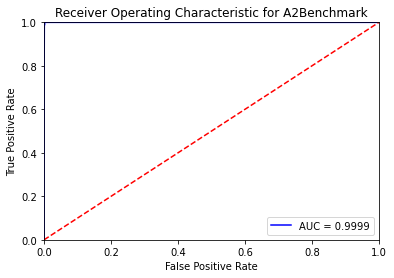

Confusion Matrix for A2 Benchmark
Classification report for A2Benchmark
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     57822
     Anomaly       0.65      1.00      0.79       210

    accuracy                           1.00     58032
   macro avg       0.82      1.00      0.89     58032
weighted avg       1.00      1.00      1.00     58032



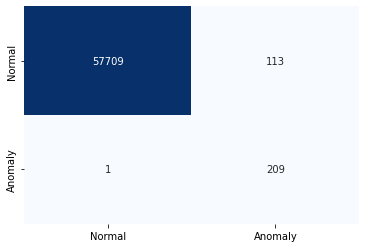

In [ ]:
# Testing the model performance on A2 Benchmark
DATASET = 'A2Benchmark' # To load time sereies data from A1 Benchmark
# DATASET = 'A1Benchmark', 'A2Benchmark', 'A3Benchmark', 'A4Benchmark'
EPOCHS = 10
TRAIN_SPLIT = 0.6
# MODEL_NAME = DATASET+'_context_withoutPER_'+str(EPOCHS)+'_split='+str(TRAIN_SPLIT)
MODEL_NAME = 'temp'
REPO_DIR = 'drive/MyDrive/dataset/ydata-labeled-time-series-anomalies-v1_0/'+DATASET

LOOK_BACK = 10
FEATURES = 2
SHAPE = (LOOK_BACK, FEATURES)

repo_files = []
repo_data = []
repo_target_data = []

x_train = []
y_train = []
x_test = []
y_test = []
total_x = []
total_y = []
data_x = []
data_y = []

for subdir, dirs, files in os.walk(REPO_DIR):
	for file in files:
		if file.find('.csv') != -1:
			repo_files.append(os.path.join(subdir, file))
	 
repo_data, repo_target_data = files_data_loading(repo_files)

total_files = len(repo_data)
for file in np.random.permutation(len(repo_target_data)):
	data_x = repo_data[file]
	data_y = repo_target_data[file]
	len_data = len(data_x)
	for index in range(0, len_data-LOOK_BACK):
		a = data_x[index: index+LOOK_BACK]
		if index == 0:
			b = np.zeros((LOOK_BACK, 1))
		else:
			b = data_y[index-1:index+LOOK_BACK-1]
		state = np.append(a, b, axis=1)
		total_x.append(state)
		total_y.append(data_y[index+LOOK_BACK-1])
		if index >= len_data*TRAIN_SPLIT:
			x_test.append(state)
			y_test.append(data_y[index+LOOK_BACK-1])
			
		else:
			x_train.append(state)
			y_train.append(data_y[index+LOOK_BACK-1])


x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = np.array(x_train)
y_train = np.array(y_train)

model = Sequential()
model.add(LSTM(128, input_shape=SHAPE))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, epochs = 10, batch_size = 128)
y_pred = model.predict(x_test, batch_size=128)

fpr, tpr, thr = roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic for A2Benchmark')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thr[optimal_idx]
# print("Threshold value is:", optimal_threshold)
y_pred_bool = (y_pred>optimal_threshold)
cf_matrix  = confusion_matrix(y_test, y_pred_bool)
axis_labels = ['Normal', 'Anomaly']
sns.heatmap(cf_matrix, cmap = 'Blues', annot=True, cbar= False, fmt='g',  xticklabels = axis_labels, yticklabels = axis_labels)
print("Confusion Matrix for A2 Benchmark")

print('Classification report for A2Benchmark')
print(classification_report(y_test, y_pred_bool,target_names=['Normal','Anomaly']))

#### Comparison of True Feedback vs Estimated Feedback and no feedback

##### In our model slection process our hypothesis was choosing a feedback would improve the performance of the model. 
##### Then we tried the following, model without feedback, true feedback and estimated feedback.
##### True feedback - append the true labels with a lag-1 to the data sequence
##### Estimated feedback - append the predicted labels with a lag-1 to the data sequence

In [ ]:
# True Feedback 
DATASET = 'A1Benchmark' # To load time sereies data from A1 Benchmark
EPOCHS = 10
TRAIN_SPLIT = 0.7
#MODEL_NAME = 'temp'
REPO_DIR = 'drive/MyDrive/dataset/ydata-labeled-time-series-anomalies-v1_0/'+DATASET

LOOK_BACK = 10
FEATURES = 2
SHAPE = (LOOK_BACK, FEATURES)

repo_files = []
repo_data = []
repo_target_data = []

x_train = []
y_train = []
x_test = []
y_test = []
total_x = []
total_y = []
data_x = []
data_y = []

for subdir, dirs, files in os.walk(REPO_DIR):
	for file in files:
		if file.find('.csv') != -1:
			repo_files.append(os.path.join(subdir, file))
	 
repo_data, repo_target_data = files_data_loading(repo_files)

total_files = len(repo_data)
for file in range(len(repo_target_data)):
	data_x = repo_data[file]
	data_y = repo_target_data[file]
	len_data = len(data_x)
	for index in range(0, len_data-LOOK_BACK):
		a = data_x[index: index+LOOK_BACK]
		if index == 0:
			b = np.zeros((LOOK_BACK, 1))
		else:
			b = data_y[index-1:index+LOOK_BACK-1]
		state = np.append(a, b, axis=1)
		total_x.append(state)
		total_y.append(data_y[index+LOOK_BACK-1])
		if index >= len_data*TRAIN_SPLIT:
			x_test.append(state)
			y_test.append(data_y[index+LOOK_BACK-1])
			
		else:
			x_train.append(state)
			y_train.append(data_y[index+LOOK_BACK-1])


x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = np.array(x_train)
y_train = np.array(y_train)

model = Sequential()
model.add(LSTM(128, input_shape=SHAPE))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, epochs = 5, batch_size = 128)
y_pred = model.predict(x_test, batch_size=128)

fpr, tpr, thr = roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thr[optimal_idx]
# print("Threshold value is:", optimal_threshold)
y_pred_bool = (y_pred>optimal_threshold)


Epoch 1/5
519/519 [==============================] - 19s 33ms/step - loss: 0.0385 - accuracy: 0.9956
Epoch 2/5
519/519 [==============================] - 17s 33ms/step - loss: 0.0185 - accuracy: 0.9965
Epoch 3/5
519/519 [==============================] - 17s 33ms/step - loss: 0.0156 - accuracy: 0.9971
Epoch 4/5
519/519 [==============================] - 17s 33ms/step - loss: 0.0136 - accuracy: 0.9974
Epoch 5/5
519/519 [==============================] - 17s 32ms/step - loss: 0.0127 - accuracy: 0.9976


In [ ]:
# Estimated feedback
y_pred_est = []
for i in range(len(x_test)):
  pred = np.reshape(model.predict(np.reshape(x_test[i], (1,10,2))), (1))
  y_pred_est.append(pred)
  if(i+1 < len(x_test)):
    for j in range(9):
      x_test[i+1][j][1] = x_test[i][j+1][1]
    x_test[i+1][9][1] = pred 

import matplotlib.pyplot as plt
fpr_est, tpr_est, thr_est = roc_curve(y_test, y_pred_est)
roc_auc_est = metrics.auc(fpr_est, tpr_est)

optimal_idx_est = np.argmax(tpr_est - fpr_est)
optimal_threshold_est = thr[optimal_idx_est]
# print("Threshold value is:", optimal_threshold)
y_pred_bool_est = (y_pred_est>optimal_threshold_est)

In [ ]:
# No feedback
DATASET = 'A1Benchmark' # To load time sereies data from A1 Benchmark
EPOCHS = 10
TRAIN_SPLIT = 0.7
#MODEL_NAME = 'temp'
REPO_DIR = 'drive/MyDrive/dataset/ydata-labeled-time-series-anomalies-v1_0/'+DATASET

LOOK_BACK = 10
FEATURES = 1
SHAPE = (LOOK_BACK, FEATURES)

repo_files = []
repo_data = []
repo_target_data = []

x_train = []
y_train = []
x_test = []
y_test = []
total_x = []
total_y = []
data_x = []
data_y = []

for subdir, dirs, files in os.walk(REPO_DIR):
	for file in files:
		if file.find('.csv') != -1:
			repo_files.append(os.path.join(subdir, file))
	 
repo_data, repo_target_data = files_data_loading(repo_files)

total_files = len(repo_data)
for file in range(total_files):
	data_x = repo_data[file]
	data_y = repo_target_data[file]
	len_data = len(data_x)
	for index in range(0, len_data-LOOK_BACK):
		a = data_x[index: index+LOOK_BACK]
		total_x.append(a)
		if index == 0:
			total_y.append(data_x[0])
		else:
			total_y.append(data_x[index+LOOK_BACK])
		
		if index >= len_data*TRAIN_SPLIT:
			x_test.append(a)
			y_test.append(data_y[index+LOOK_BACK])
		else:
			x_train.append(a)
			y_train.append(data_y[index+LOOK_BACK])

x_test = np.array(x_test)
y_test_no = np.array(y_test)
x_train = np.array(x_train)
y_train = np.array(y_train)

model = Sequential()
model.add(LSTM(128, input_shape=SHAPE))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, epochs = 10, batch_size = 128, shuffle=False)
y_pred_no = model.predict(x_test, batch_size=64)

fpr_no, tpr_no, thr_no = roc_curve(y_test_no, y_pred_no)
roc_auc_no = metrics.auc(fpr_no, tpr_no)

optimal_idx_no = np.argmax(tpr_no - fpr_no)
optimal_threshold_no = thr_no[optimal_idx_no]
# print("Threshold value is:", optimal_threshold)
y_pred_bool_no = (y_pred_no>optimal_threshold_no)


Epoch 1/10
519/519 [==============================] - 19s 32ms/step - loss: 0.0759 - accuracy: 0.9896
Epoch 2/10
519/519 [==============================] - 17s 32ms/step - loss: 0.0589 - accuracy: 0.9906
Epoch 3/10
519/519 [==============================] - 17s 32ms/step - loss: 0.0578 - accuracy: 0.9906
Epoch 4/10
519/519 [==============================] - 17s 32ms/step - loss: 0.0582 - accuracy: 0.9906
Epoch 5/10
519/519 [==============================] - 17s 33ms/step - loss: 0.0575 - accuracy: 0.9906
Epoch 6/10
519/519 [==============================] - 17s 33ms/step - loss: 0.0573 - accuracy: 0.9906
Epoch 7/10
519/519 [==============================] - 17s 34ms/step - loss: 0.0579 - accuracy: 0.9906
Epoch 8/10
519/519 [==============================] - 17s 33ms/step - loss: 0.0577 - accuracy: 0.9906
Epoch 9/10
519/519 [==============================] - 17s 33ms/step - loss: 0.0577 - accuracy: 0.9906
Epoch 10/10
519/519 [==============================] - 17s 33ms/step - loss: 0.058

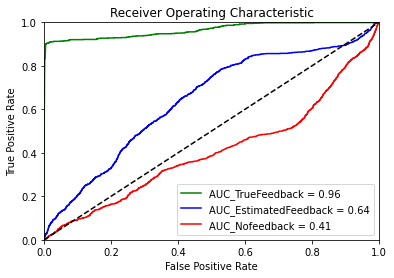

In [ ]:
#To plot multiple RoC on single plot
plt.plot(fpr, tpr, 'g', label = 'AUC_TrueFeedback = %0.2f' % roc_auc)
plt.plot(fpr_est, tpr_est, 'b', label = 'AUC_EstimatedFeedback = %0.2f' % roc_auc_est)
plt.plot(fpr_no, tpr_no, 'r', label = 'AUC_Nofeedback = %0.2f' % roc_auc_no)
plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Imbalaned Data Problem

In [ ]:
# We have tried oversampling, undersampling and oversampling followed by undersampling. To get a flavour of what is done see the code below

undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)

data_x_old, data_y_old = undersample.fit_resample(data_xim, data_yim)

# Any of the above mentioned techniques give normal class followed by anomaly class
idx = np.random.permutation(len(data_x_old))
for i in range(len(data_x_old)):
  data_x[i],data_y[i] = data_x_old[idx[i]], data_y_old[idx[i]]

The above mentioned techniques did not improve the performance much. 

### End